# Question 5: RNN - LSTM
- Use AAPL.csv dataset or dowload from link https://finance.yahoo.com/quote/AAPL/history?period1=1479081600&period2=1605312000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
- Requirement:
  + Build a model to predict the tomorrow's Open value based on the today's Open, High, Low, Close, Adj Close, Volume

# 0.Mount drive & Import packages

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS8_K270_ONLINE_DamThiMinhPhuong/LDS8_K270_DamThiMinhPhuong_Cuoi_ky/Question5_RNN'

/content/gdrive/My Drive/LDS8_K270_ONLINE_DamThiMinhPhuong/LDS8_K270_DamThiMinhPhuong_Cuoi_ky/Question5_RNN


In [ ]:
# LSTM for air pollution problem with regression framing
import pandas as pd
import numpy
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping  

# 1. Load & Prepare data

In [ ]:
#load dataset
dataset= pd.read_csv('AAPL.csv', index_col=0)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1008 entries, 2016-11-14 to 2020-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1008 non-null   float64
 1   High       1008 non-null   float64
 2   Low        1008 non-null   float64
 3   Close      1008 non-null   float64
 4   Adj Close  1008 non-null   float64
 5   Volume     1008 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.1+ KB


In [ ]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1008.000000,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03
mean,55.022847,55.634645,54.439440,55.068780,53.661965,1.279139e+08
std,22.808228,23.199504,22.329356,22.778370,23.265842,5.914382e+07
min,26.642500,26.920000,26.020000,26.427500,24.825821,2.880380e+07
25%,39.973123,40.278123,39.636251,39.968751,38.069605,8.788140e+07
50%,47.244999,47.631248,46.872500,47.197500,45.769047,1.118354e+08
75%,61.968749,63.971249,61.203751,62.090624,61.046269,1.499102e+08
max,137.589996,137.979996,130.529999,134.179993,133.948898,4.479400e+08


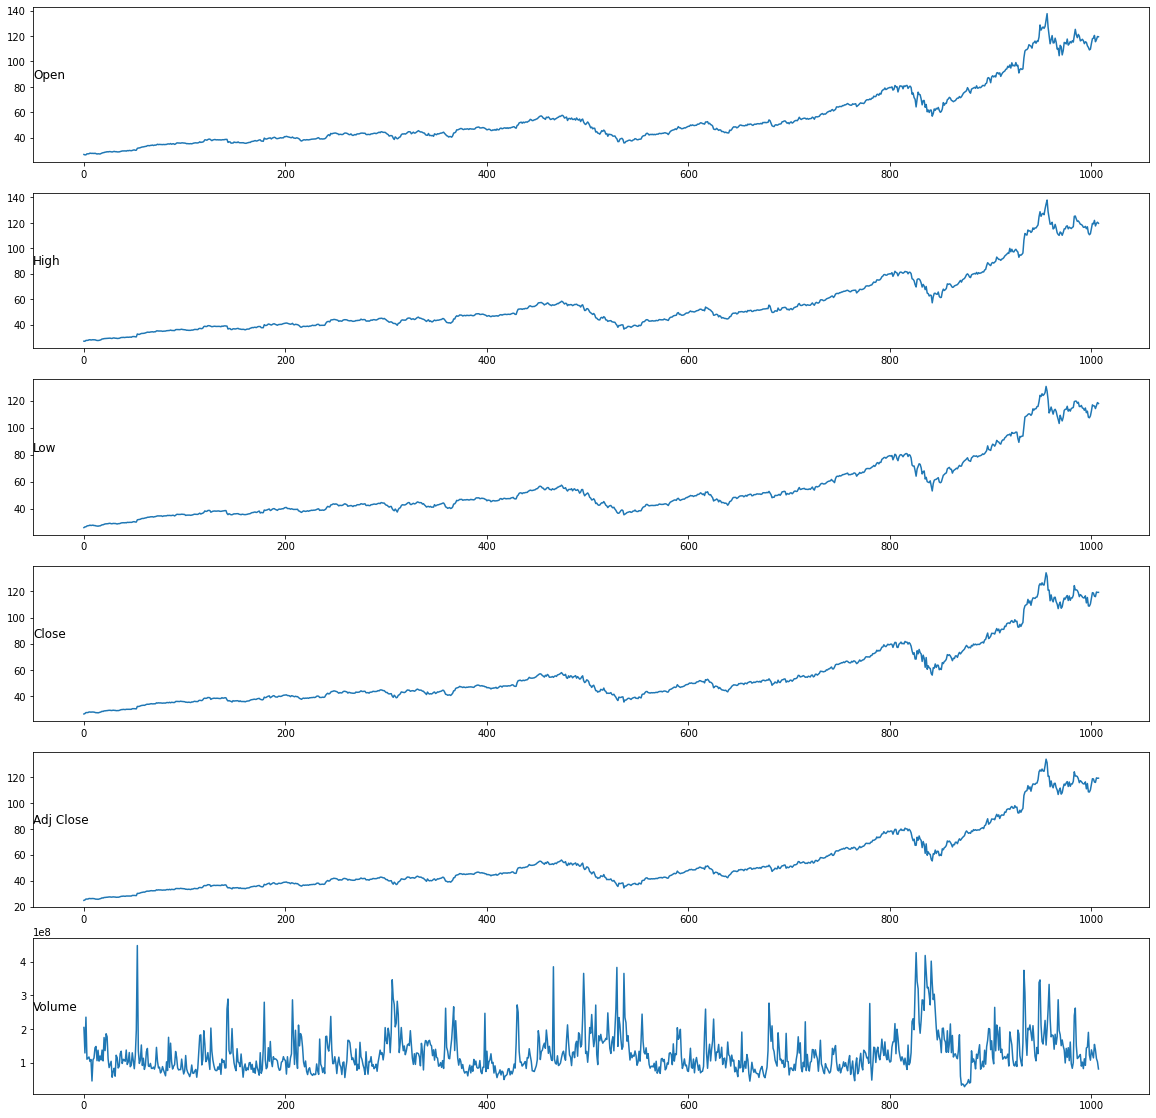

In [ ]:
values = dataset.values
# specific column to plot
groups = [0,1,2,3,4,5]   
i = 1
# plot each column
plt.figure(figsize=(20,20))
for group in groups:
  plt.subplot(len(groups),1,i)
  plt.plot(values[:,group])
  plt.title(dataset.columns[group], y=0.5, loc='left')
  i+=1
plt.show()

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))        
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True) # kết quả sau khi drop gán luôn vào agg
	return agg


In [ ]:
# Normalize feature
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(values)
scaled = scaler.transform(values)
print('Frame as Series:')
print(scaled[:5])
# Frame as supervised learning 
reframed = series_to_supervised(scaled,1)
print('Frame as supervised learning:')
print(reframed.head())

Frame as Series:
[[2.56878262e-03 2.92625618e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.19668356e-01]
 [0.00000000e+00 0.00000000e+00 4.97561004e-03 3.24818471e-03
  3.01301071e-03 2.39192415e-01]
 [2.92922339e-04 5.74014968e-03 6.02813134e-03 9.93015540e-03
  9.21115888e-03 4.92818802e-01]
 [7.30074160e-03 6.01026494e-03 1.13625491e-02 9.83735012e-03
  9.12503594e-03 1.94982442e-01]
 [7.09795199e-03 6.43796169e-03 1.33480147e-02 1.00925646e-02
  9.36178697e-03 2.02587608e-01]]
Frame as supervised learning:
   var1(t-1)  var2(t-1)  var3(t-1)  ...   var4(t)   var5(t)   var6(t)
1   0.002569   0.000293   0.000000  ...  0.003248  0.003013  0.239192
2   0.000000   0.000000   0.004976  ...  0.009930  0.009211  0.492819
3   0.000293   0.005740   0.006028  ...  0.009837  0.009125  0.194982
4   0.007301   0.006010   0.011363  ...  0.010093  0.009362  0.202588
5   0.007098   0.006438   0.013348  ...  0.013967  0.012956  0.210563

[5 rows x 12 columns]


In [ ]:
# Vì chỉ predict var1(t), còn từ var2(t) trở đi không dự đoán nên drop
# giữ các cột từ 0-6 (6 cột đầu là inpus, cột cuối là output)
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print('Frame will use:')
reframed.head()

Frame will use:


,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.002569,0.000293,0.000000,0.000000,0.000000,0.419668,0.000000
2,0.000000,0.000000,0.004976,0.003248,0.003013,0.239192,0.000293
3,0.000293,0.005740,0.006028,0.009930,0.009211,0.492819,0.007301
4,0.007301,0.006010,0.011363,0.009837,0.009125,0.194982,0.007098
5,0.007098,0.006438,0.013348,0.010093,0.009362,0.202588,0.007999


In [ ]:
# Split into train/ test
values = reframed.values 
n_train_hours = 365 * 2 #dữ liệu theo ngày, lấy 2 năm đầu để train
train = values[:n_train_hours,:]
test = values[n_train_hours:,:]
# Split into input/output
trainX, trainY = train[:,:-1], train[:,-1]
testX, testY = test[:,:-1], test[:,-1]
print('Before reshape:')
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

Before reshape:
(730, 6) (730,) (277, 6) (277,)


In [ ]:
# Reshape input to be 3D [samples, timesteps, features]
trainX = trainX.reshape(trainX.shape[0],1,trainX.shape[1])
testX = testX.reshape(testX.shape[0],1,testX.shape[1])
print('After reshape:')
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

After reshape:
(730, 1, 6) (730,) (277, 1, 6) (277,)


# 2. Build RNN netwỏk

### 2.1 Model 1

In [ ]:
# Build network
model = Sequential()
model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2])))  
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4992      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


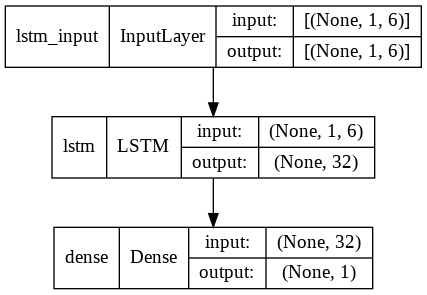

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='AAPL_manyTo1_model1.png', show_shapes=True)
Image(filename='AAPL_manyTo1_model1.png')

In [ ]:
model.compile(loss='mae', optimizer='adam')

In [ ]:
# Early Stopping 
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0.0001, # minimium amount of change to count as an improvement     
                               patience=20, # how many epochs to wait before stopping     
                               restore_best_weights=True, )

In [ ]:
history = model.fit(trainX, trainY, 
                    validation_data=(testX, testY),
                    epochs=50,
                    batch_size=64,
                    callbacks=early_stopping,
                    verbose=0
                    )

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss,val_loss
25,0.003392,0.039561
26,0.003370,0.032946
27,0.003338,0.035746
28,0.003261,0.031930
29,0.003292,0.030444


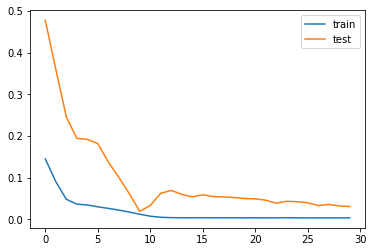

In [ ]:
# plot history 
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

### 2.2 Model 2

In [ ]:
model2 = Sequential()
model2.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))  
model2.add(Dense(1))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               69120     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


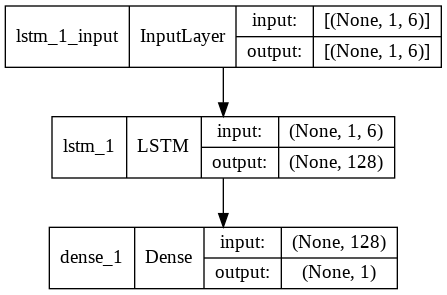

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model2, to_file='AAPL_manyTo1_model2.png', show_shapes=True)
Image(filename='AAPL_manyTo1_model2.png')

In [ ]:
model2.compile(loss='mae', optimizer='adam')

In [ ]:
history2 = model2.fit(trainX, trainY, 
                    validation_data=(testX, testY),
                    epochs=50,
                    batch_size=128,
                    callbacks=early_stopping,
                    verbose=0
                    )

In [ ]:
history2_df = pd.DataFrame(history2.history)
history2_df.tail()

,loss,val_loss
26,0.003011,0.027715
27,0.003041,0.027465
28,0.003033,0.027763
29,0.003000,0.027017
30,0.003074,0.025700


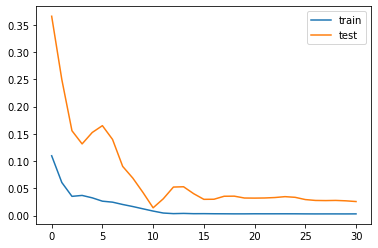

In [ ]:
# plot history 
plt.plot(history2.history['loss'], label='train') 
plt.plot(history2.history['val_loss'], label='test') 
plt.legend() 
plt.show()

### Nhận xét:
- Model2 cho loss & val_loss thấp hơn Model 1 nên chọn Model 2

# 3. Evaluation

In [ ]:
def invert_scaling(y, X, s):
    # invert scaling for forecast
    inv_y = numpy.concatenate((y, X[:, 1:]), axis=1)
    print(s, "shape:", inv_y.shape)
    inv_y = scaler.inverse_transform(inv_y)
    print(s, inv_y.shape)
    # trả lại hình dạng ban đầu
    inv_y = inv_y[:,0]
    return inv_y

In [ ]:
#make prediction for TEST data
yhat = model2.predict(testX)
print('X test shape:', testX.shape)
testX_now = testX.reshape((testX.shape[0], testX.shape[2]))
print('X test now shape:',testX_now.shape)

inv_yhat = invert_scaling(yhat, testX_now, 'inv_yhat')
testY = testY.reshape(len(testY),1)
inv_y = invert_scaling(testY, testX_now, 'inv_y')

X test shape: (277, 1, 6)
X test now shape: (277, 6)
inv_yhat shape: (277, 6)
inv_yhat (277, 6)
inv_y shape: (277, 6)
inv_y (277, 6)


In [ ]:
#calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.2f RMSE' %(rmse))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.2f MAE' %(mae))

Test RMSE: 2.08 RMSE
Test RMSE: 1.58 MAE


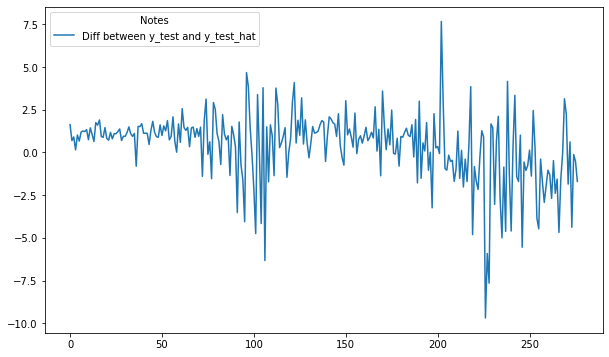

In [ ]:
# plot baseline and predictions 
plt.figure(figsize=(10,6)) 
plt.plot(inv_y - inv_yhat, label='Diff between y_test and y_test_hat') 
plt.legend(title="Notes") 
plt.show()

In [ ]:
#make prediction for TRAIN data
yhat_train = model.predict(trainX)
print('X train shape:', trainX.shape)
trainX_now = trainX.reshape((trainX.shape[0], trainX.shape[2]))
print('X train now shape:',trainX.shape)

inv_yhat_train = invert_scaling(yhat_train, trainX_now, 'inv_yhat_train')
trainY = trainY.reshape(len(trainY),1)
inv_y_train= invert_scaling(trainY, trainX_now, 'inv_y_train')

X train shape: (730, 1, 6)
X train now shape: (730, 1, 6)
inv_yhat_train shape: (730, 6)
inv_yhat_train (730, 6)
inv_y_train shape: (730, 6)
inv_y_train (730, 6)


In [ ]:
#calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y_train, inv_yhat_train))
print('Test RMSE: %.2f RMSE' %(rmse))
mae = mean_absolute_error(inv_y_train, inv_yhat_train)
print('Test RMSE: %.2f MAE' %(mae))

Test RMSE: 1.33 RMSE
Test RMSE: 1.03 MAE


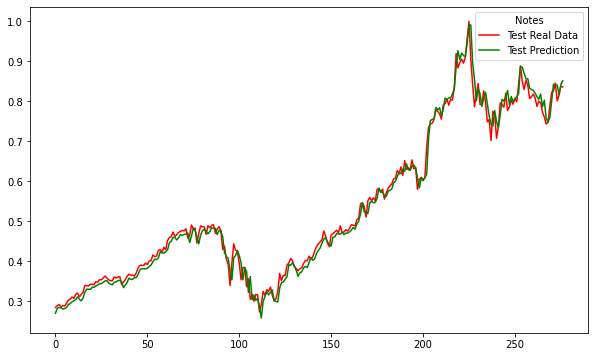

In [ ]:
# plot baseline and predictions
plt.figure(figsize=(10,6))
plt.plot(testY, label='Test Real Data', color='r')
plt.plot(yhat, label='Test Prediction', color='g')
plt.legend(title='Notes')
plt.show()

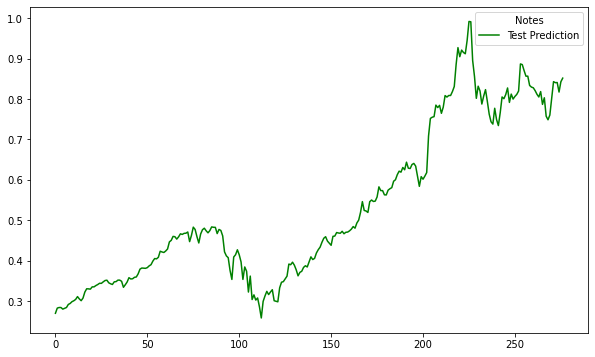

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(yhat, label='Test Prediction', color='g')
plt.legend(title='Notes')
plt.show()

In [ ]:
print('Val_loss_train')
model.evaluate(trainX, trainY)

Val_loss_train
23/23 [==============================] - 1s 2ms/step - loss: 0.0093


0.009280391037464142

In [ ]:
print('Val_loss_test')
model.evaluate(testX, testY)

Val_loss_test
9/9 [==============================] - 0s 3ms/step - loss: 0.0189


0.018866853788495064

### Nhận xét:
- loss & val_loss rất nhỏ => mô hình phù hợp

In [ ]:
# Save the result
model2.save('AAPL_many_to_one.h5')

#4. Make new prediction

In [ ]:
dataset= pd.read_csv('AAPL.csv', index_col=0)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-11-14,26.927500,26.952499,26.020000,26.427500,24.825821,204702000
2016-11-15,26.642500,26.920000,26.540001,26.777500,25.154610,129058000
2016-11-16,26.674999,27.557501,26.650000,27.497499,25.830971,235362000
2016-11-17,27.452499,27.587500,27.207500,27.487499,25.821573,110528000
2016-11-18,27.430000,27.635000,27.415001,27.514999,25.847408,113715600


In [ ]:
dataset.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-09,120.500000,121.989998,116.050003,116.320000,116.320000,154515300
2020-11-10,115.550003,117.589996,114.129997,115.970001,115.970001,138023400
2020-11-11,117.190002,119.629997,116.440002,119.489998,119.489998,112295000
2020-11-12,119.620003,120.529999,118.570000,119.209999,119.209999,103162300
2020-11-13,119.440002,119.669998,117.870003,119.260002,119.260002,81581900


In [ ]:
dataset_new = pd.read_csv('AAPL_predict.csv', index_col = 0,)
dataset_new

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
11/13/20,119.440002,119.669998,117.870003,119.260002,119.260002,81581900
12/13/20,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [ ]:
values_new = dataset_new.values
values_new

array([[1.19440002e+02, 1.19669998e+02, 1.17870003e+02, 1.19260002e+02,
        1.19260002e+02, 8.15819000e+07],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [ ]:
#MinMaxScaler
scaled_new = scaler.transform(values_new)
scaled_new

array([[ 0.83640916,  0.83513417,  0.8788633 ,  0.86153461,  0.86539148,
         0.12592112],
       [-0.24013611, -0.24239151, -0.24897139, -0.24526115, -0.22750294,
        -0.06872181]])

In [ ]:
#convert datafram as supervised learning
reframed_new = series_to_supervised(scaled_new,1)
reframed_new.drop(reframed_new.columns[[7,8,9,10,11]], axis=1, inplace=True)
reframed_new.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
1,0.836409,0.835134,0.878863,0.861535,0.865391,0.125921,-0.240136


In [ ]:
reframed_new.shape

(1, 7)

In [ ]:
values_new = reframed_new.values
# Split into input/output
new_pre = values_new[:,:-1]
new_pre.shape
# Reshape input to be 3D[samples, timesteps,features]
new_pre = new_pre.reshape((new_pre.shape[0],1,new_pre.shape[1]))
new_pre.shape

(1, 1, 6)

In [ ]:
yhat_new_pre = model2.predict(new_pre)
yhat_new_pre

array([[0.8481808]], dtype=float32)

In [ ]:
# invert scaling for actual
yhat_new_pre = yhat_new_pre.reshape(len(yhat_new_pre),1)
new_pre_now = new_pre.reshape((new_pre.shape[0],new_pre.shape[2]))
yhat_new_pre = invert_scaling(yhat_new_pre, new_pre_now, 'yhat_new_pre')
yhat_new_pre

yhat_new_pre shape: (1, 6)
yhat_new_pre (1, 6)


array([120.74603268])